In [13]:
import findspark
findspark.init()

In [2]:
from pyspark import SparkContext
sc = SparkContext()
sc

<SparkContext master=yarn appName=pyspark-shell>

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("final_eda").getOrCreate()

In [4]:
data = spark.read.parquet("s3://ppol567lab2/datasample.parquet")

In [5]:
#getting sample for eda 
sample = data.sample(False, .022, seed = 123)

In [6]:
sample.count()

961548

In [7]:
#converting to pandas df
sample = sample.toPandas()

/usr/lib/spark/python/pyspark/sql/dataframe.py:2103: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 0.8.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)


In [8]:
sample.head()

,author,author_cakeday,body,author_patreon_flair,can_gild,controversiality,collapsed,score,subreddit,comment,post,moderator,admin
0,nocturtleatnight,None,Idk guys he was only 2-3ft out of bounds. Pret...,False,True,0,False,2,nba,0,1,0,0
1,Apo5tropi,None,Lol,False,True,0,False,4,MotoX4,1,0,0,0
2,MarvelKenneth,None,"This. LBP pulled it off effectively, so Mario ...",False,True,0,False,3,NintendoSwitch,1,0,0,0
3,Quaig,None,L09,False,True,0,False,2,Huawei,1,0,0,0
4,magpiec,None,And they add to the view when lit up at night,False,True,0,False,2,ViewPorn,1,0,0,0


In [12]:
import matplotlib.pyplot as plt

In [17]:
#looking at subreddits with highest activity
top_subreds = sample.groupby('subreddit')['subreddit'].count()\
      .reset_index(name = 'count')

In [29]:
#getting subredcits w/ highest percentage
top_subreds['total'] = len(sample)
top_subreds['percent'] = round((top_subreds['count']/top_subreds['total']) * 100, 2)
top_subreds.head()

,subreddit,count,total,percent
1076,AskReddit,50964,961548,5.30
21864,politics,17155,961548,1.78
21017,nfl,11768,961548,1.22
18110,funny,8588,961548,0.89
20905,nba,8482,961548,0.88


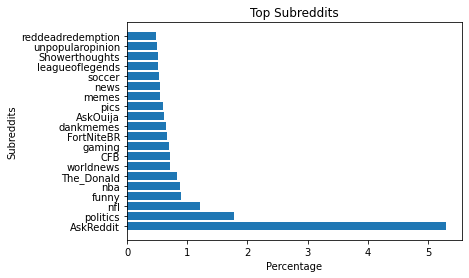

In [31]:
#barplot of top subreddits
plt.barh(top_subreds['subreddit'] ,top_subreds['percent'])
plt.title('Top Subreddits')
plt.ylabel('Subreddits')
plt.xlabel('Percentage')
plt.show()

In [109]:
#getting numeric columns for correlation plot
non_objects = sample.select_dtypes(exclude=['object'])
non_objects.head()

,can_gild,controversiality,collapsed,score,comment,post,moderator,admin
0,True,0,False,2,0,1,0,0
1,True,0,False,4,1,0,0,0
2,True,0,False,3,1,0,0,0
3,True,0,False,2,1,0,0,0
4,True,0,False,2,1,0,0,0


In [95]:
#looking at correlation
non_objects.corr().style.background_gradient(cmap='coolwarm')

,can_gild,controversiality,collapsed,score,comment,post,moderator,admin,author_age
can_gild,1.000000,-0.003976,-0.008047,0.001862,0.001854,-0.001854,0.013555,0.000268,0.013959
controversiality,-0.003976,1.000000,0.063096,-0.011287,0.027248,-0.027248,-0.015791,-0.000341,0.002656
collapsed,-0.008047,0.063096,1.000000,-0.023797,0.022895,-0.022895,-0.015871,-0.000274,-0.027958
score,0.001862,-0.011287,-0.023797,1.000000,-0.011610,0.011610,-0.009108,0.000110,-0.027524
comment,0.001854,0.027248,0.022895,-0.011610,1.000000,-1.000000,-0.123616,0.001993,-0.228802
post,-0.001854,-0.027248,-0.022895,0.011610,-1.000000,1.000000,0.123616,-0.001993,0.228802
moderator,0.013555,-0.015791,-0.015871,-0.009108,-0.123616,0.123616,1.000000,-0.000301,0.883114
admin,0.000268,-0.000341,-0.000274,0.000110,0.001993,-0.001993,-0.000301,1.000000,nan
author_age,0.013959,0.002656,-0.027958,-0.027524,-0.228802,0.228802,0.883114,nan,1.000000


In [45]:
#count of controversiality type
contro  = sample.groupby('controversiality')['controversiality'].count().reset_index(name = 'count')
contro.controversiality = contro.controversiality.astype('string')
contro.head()

,controversiality,count
0,0,940537
1,1,21011


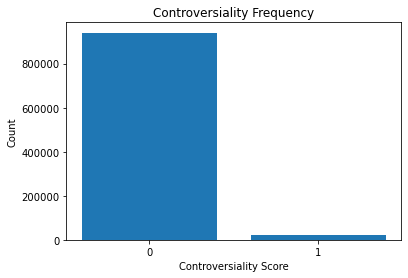

In [52]:
#plotting
plt.bar(x = contro.controversiality, height = contro['count'])
plt.title("Controversiality Frequency")
plt.xlabel("Controversiality Score")
plt.ylabel("Count")
plt.show()

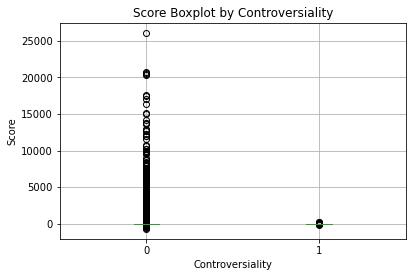

In [63]:
#looking at distribution of score per controversiality type
sample.boxplot(column = ['score'], by= ['controversiality'])
plt.xlabel("Controversiality")
plt.ylabel("Score")
plt.title("Score Boxplot by Controversiality")
plt.suptitle('') 
plt.show()

<AxesSubplot:ylabel='Density'>

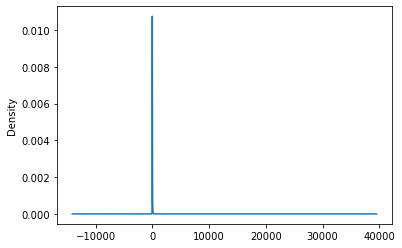

In [72]:
#looking at distribution of scores
sample.score.plot(kind='density')

(array([9.61183e+05, 2.54000e+02, 6.40000e+01, 2.10000e+01, 9.00000e+00,
        8.00000e+00, 4.00000e+00, 4.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([ -723.,  1960.,  4643.,  7326., 10009., 12692., 15375., 18058.,
        20741., 23424., 26107.]),
 <BarContainer object of 10 artists>)

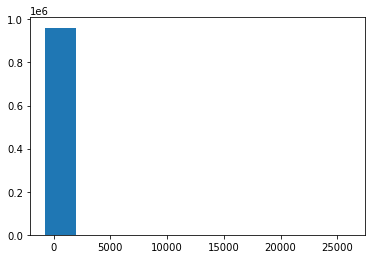

In [71]:
plt.hist(sample.score)

In [68]:
#looking at summary statistics of score
sample.score.describe()

count    961548.000000
mean          9.570719
std         120.982291
min        -723.000000
25%           1.000000
50%           2.000000
75%           4.000000
max       26107.000000
Name: score, dtype: float64

In [73]:
#removing outliers
filtered = sample[sample.score < 20000]

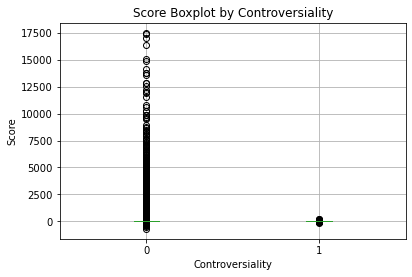

In [74]:
#reexaminig score distribution by controversiality type
filtered.boxplot(column = ['score'], by= ['controversiality'])
plt.xlabel("Controversiality")
plt.ylabel("Score")
plt.title("Score Boxplot by Controversiality")
plt.suptitle('') 
plt.show()

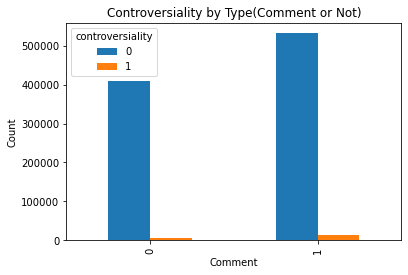

In [104]:
#plotting conversiality type depending of it is a comment or post
df = sample.groupby(['comment', "controversiality"])['comment'].count().reset_index(name = 'val')
df.pivot("comment", "controversiality", "val").plot(kind='bar')
plt.title("Controversiality by Type(Comment or Not)")
plt.xlabel("Comment")
plt.ylabel("Count")
plt.show()

In [16]:
#subreddits with highest score
sample.groupby('subreddit')['score'].max().reset_index(name = 'max score').sort_values('max score', ascending = False)

,subreddit,max score
1112,AskReddit,26107
21759,pics,20732
13492,Unexpected,20559
18249,gaming,14924
11521,Showerthoughts,14236
...,...,...
24858,u_QuitePetite,-22
2508,CelebSexScenes,-23
12761,TheLastLeg,-24
13661,Vault_Tec_Corporation,-26


In [24]:
#subreddits with most controversialty
sub_controv = sample.groupby(['subreddit', 'controversiality'])['controversiality'].count().reset_index(name = 'count').sort_values('count', ascending = False)

In [25]:
sub_controv[sub_controv.controversiality == 1]

,subreddit,controversiality,count
24303,politics,1,646
1235,AskReddit,1,573
29027,worldnews,1,494
23323,news,1,480
23219,nba,1,377
...,...,...,...
13912,Tgirls,1,1
13917,ThailandTourism,1,1
13870,Tennessee,1,1
13821,TechNewsToday,1,1
